In [1]:

import torch
import copy
import random
from torch import optim
from torch import nn
from torch.autograd import Variable
from VAE import *
from VAE2 import *
from Inference import *
from Train_data import *
import numpy as np

# num_user     = 100
# num_genre    = 10
# num_contents = 2000
# num_request  = 1000
# num_zone     = 2
# info = [num_user, num_genre, num_contents, num_request, num_zone]

class ES():
    def __init__(self, size, load, device, info):
        self.size = size
        self.model  = VAE().to(device)
        self.gmodels = None
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3,  amsgrad=True)
        self.clients = [None]*size
        self.count   = 0
        self.ESe     = 0 
        self.load    = load
        self.load_s  = 0
        self.device = device
        self.dist = None
        self.info = info
        self.num_user, self.num_genre, self.num_contents, self.num_request, self.num_zone = info
        for i in load:
            self.load_s+=i
    
    def inference_dist(self):
        temp = []
        for i in self.gmodels:
            temp.append(inference(i, self.info, mode ='split'))
        self.dist = temp
    
    def split_model(self):
        models = [VAE2().to("cuda:0") for _ in range(self.num_genre)]
        gdict = []
        w = self.model.state_dict()
        ptr = self.num_contents//self.num_genre
        for g in range(self.num_genre):
            wt = copy.deepcopy(w)
            w1 = w["fc1.weight"][:,g*ptr:(g+1)*ptr]
            w2 = w["fc4.weight"][g*ptr:(g+1)*ptr,:]
            w2b = w["fc4.bias"][g*ptr:(g+1)*ptr]
            wt["fc1.weight"] = w1
            wt["fc4.weight"] = w2
            wt["fc4.bias"] = w2b
            gdict.append(wt)
            
        for g in range(self.num_genre):
            models[g].load_state_dict(gdict[g])
        
        self.gmodels = models
        
        
    def average_weights(self,clients):
        ws = copy.deepcopy(clients[0])
        for idx, info in enumerate(clients[1:]):
            for key in info:
                ### 수정했음 ### 0722_Client 0 -> global로 바뀌는 문제 해결
                if idx == 0:
                    ws[key] = self.load[idx+1]*info[key] + self.load[idx]*ws[key]
                else:
                    ws[key] += self.load[idx+1]*info[key]
                    
        for key in ws:
            ws[key]=ws[key]/self.load_s
        weights=ws
        return weights

    def aggregate(self):
        ## overlapped client weight gamma needed 
        weights_info = self.clients
        weights = self.average_weights(weights_info)
        self.model.load_state_dict(weights)
        
    def global_weight(self):
        weights = self.model.state_dict()
        return weights
    def sample(self):
        return self.model.sample()

In [14]:
def CDF(p):    
    dist = [0 for i in range(len(p))]
    for i in range(len(p)):
        for j in range(0, i+1):
            dist[i] += p[j]

    dist = np.array(dist)
    return dist

def binary_search(cdf, target, left, right):
    while left < right:
        mid = (left + right) // 2
        if cdf[mid] < target:
            left = mid + 1
        else:
            right = mid
    return left

def inverse_transform_sampling(cdf, n_samples, left, right, seed):
    np.random.seed(seed)
    u = np.random.rand(n_samples)
    samples = [binary_search(cdf, uu, left, right) for uu in u]
    return samples

In [15]:
class Client():
    def __init__(self, rank, data, local_epoch, ES):
        # seed
        seed = 19201077 + 19950920 + rank
        torch.manual_seed(seed)
        self.rank = rank
        self.local_epoch = local_epoch
        self.ES = ES
        self.model = VAE().to(ES.device)
        self.ws = None
        self.data = data
        self.num_user, self.num_genre, self.num_contents, self.num_request, self.num_zone = ES.info
        gr = [0 for _ in range(self.num_genre)]
        for i in self.data:
            for idx, j in enumerate(i):
                if j != 0:
                    g = idx//(self.num_contents//self.num_genre)
                    gr[g] += j
        gr = [torch.tensor(gr).topk(self.num_genre)[0].tolist(), torch.tensor(gr).topk(self.num_genre)[1].tolist()]
        self.rk = gr
    
    def load_global_model(self):
        model = VAE().to(self.ES.device)
        model.load_state_dict(self.ES.model.state_dict()) 
        return model

    def train(self, model, batch, num_epochs = 10):
        # update local model
        optimizer = optim.Adam(model.parameters(), lr=1e-3,  amsgrad=True)
        #num_epochs = 10
        #batch = self.data
        for _ in range(num_epochs):
            model.train()
            train_loss = 0.0
            batch = torch.tensor(batch, dtype=torch.float32).to(self.ES.device)
            inputs = batch
            optimizer.zero_grad()
            reconstructed_x, mean, logvar = model(inputs)
            
            # Reconstruction loss
            reconstruction_loss = F.binary_cross_entropy(reconstructed_x, inputs, reduction='sum')

            # KL divergence loss
            kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

            # Total loss
            loss = reconstruction_loss + kl_divergence_loss
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        # Print progress
        # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))

    def set_data(self):
        dist = self.ES.dist
        data  = []
        rk    = self.rk[1]
        rt    = self.rk[0]
        
        for idx, g in enumerate(rk):
            dt = inverse_transform_sampling(cdf = CDF(dist[g]),
                        n_samples = int(rt[idx]),
                        left = 0, right = self.num_contents//self.num_genre - 1, seed = self.ES.ESe)
            for c in dt:
                ct = c + (self.num_contents//self.num_genre)*g
                data.append(int(ct))
        random.shuffle(data)
        bs_data = []
        
        for b in range(len(data)//5):
            temp = [0 for _ in range(self.num_contents)] 
            for c in range(5):
                idx = data[5*b+c]
                temp[idx] += 1
            bs_data.append(temp)
            
        return bs_data
    
    def run(self):
        if self.ES.ESe != 0:
            data = self.set_data()
            self.train(self.model, data, num_epochs=10)
            
        elif self.ES.ESe == 0:
            self.model = self.load_global_model()
            
        self.train(self.model, self.data, num_epochs=10)
        self.ES.clients[self.ES.count%self.ES.size] = self.model.state_dict()
        self.ES.count += 1


In [16]:
def fed_VAE(src, info):
    num_user     = 100
    num_genre    = 10
    num_contents = 2000
    num_request  = 1000
    num_zone     = 2
    info = [num_user, num_genre, num_contents, num_request, num_zone]
    n_ES       = 2
    n_client   = num_user
    ES_epoch    = 100
    ESs = []
    clients = [[ None for i in range(n_client)] for j in range(n_ES) ]
    load1 = [num_request for i in range(num_user)]
    print('Initialize Dataset...')
    for i in range(n_ES):
        ESs.append(ES(size=n_client, load = load1, device = "cuda:0", info = info))
        for j in range(n_client):
            clients[i][j] = Client(rank=j, 
                                 data = src[i][j], 
                                 local_epoch=10, 
                                 ES = ESs[i] )

    for ESe in range(ES_epoch):
        print('\n================== Edge Server Epoch {:>3} =================='.format(ESe + 1))

        for ESn in range(n_ES):
            #print("================= Edge Server :",ESn,"process =================")
            for c in clients[ESn]:
                c.run()
        
                
            ESs[ESn].aggregate()
            ESs[ESn].split_model()
            ESs[ESn].inference_dist()
            ESs[ESn].ESe += 1
            
    weight1 = ESs[0].global_weight()
    weight2 = ESs[1].global_weight()
    weight3 = ESs[0].clients
    weight4 = ESs[1].clients
    

    return weight1, weight2, weight3, weight4

In [17]:
import pickle
with open("1000_0317_raw.pkl", "rb") as f:
    src = pickle.load(f)
src = train_data(info, src, bs = 5, option =  "default")

In [18]:
w1, w2, w3, w4 = fed_VAE(src)

Initialize Dataset...

================== Edge Server Epoch   1 ==================


C:\Users\amky9\AppData\Local\Temp\ipykernel_18172\1523841305.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=torch.float32).to(self.ES.device)



================== Edge Server Epoch   2 ==================

================== Edge Server Epoch   3 ==================

================== Edge Server Epoch   4 ==================

================== Edge Server Epoch   5 ==================

================== Edge Server Epoch   6 ==================

================== Edge Server Epoch   7 ==================

================== Edge Server Epoch   8 ==================

================== Edge Server Epoch   9 ==================

================== Edge Server Epoch  10 ==================

================== Edge Server Epoch  11 ==================

================== Edge Server Epoch  12 ==================

================== Edge Server Epoch  13 ==================

================== Edge Server Epoch  14 ==================

================== Edge Server Epoch  15 ==================

================== Edge Server Epoch  16 ==================

================== Edge Server Epoch  17 ==================

================== Edge

In [19]:
# with open("0722_w.pkl", "wb") as f:
#     pickle.dump([w1,w2,w3,w4], f)

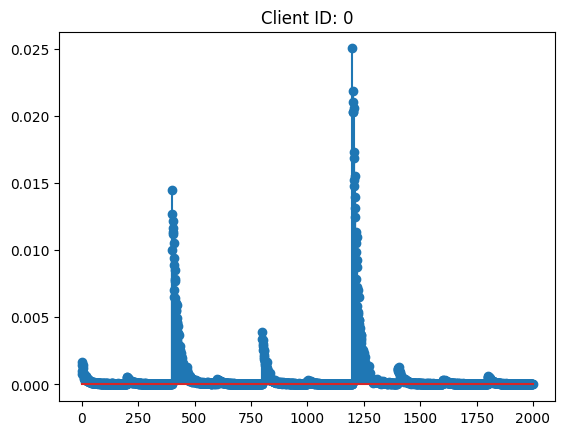

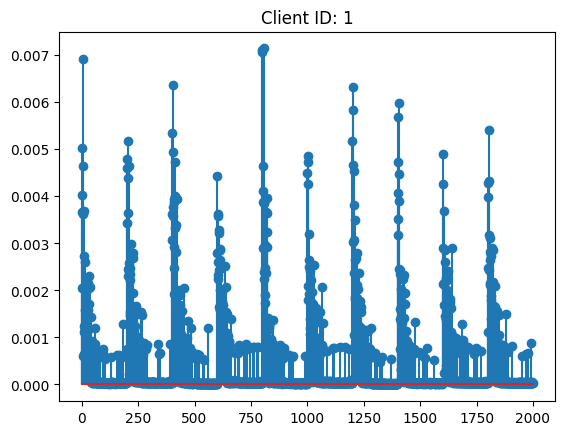

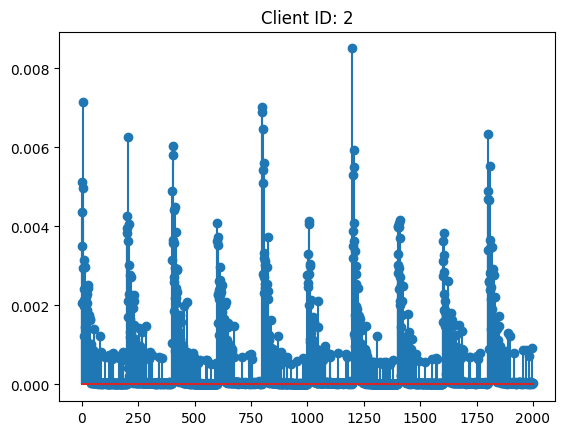

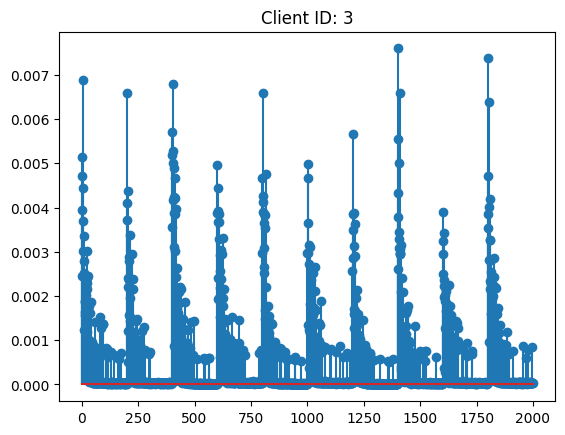

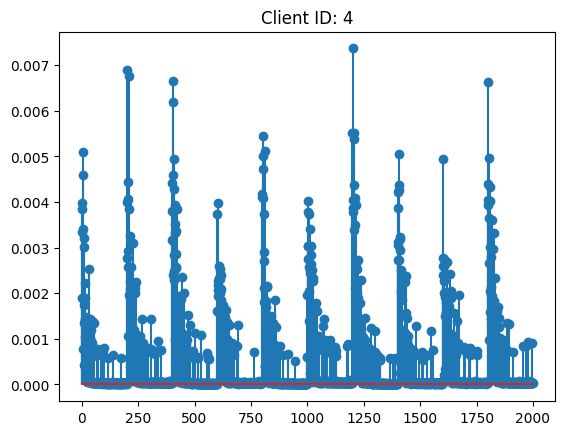

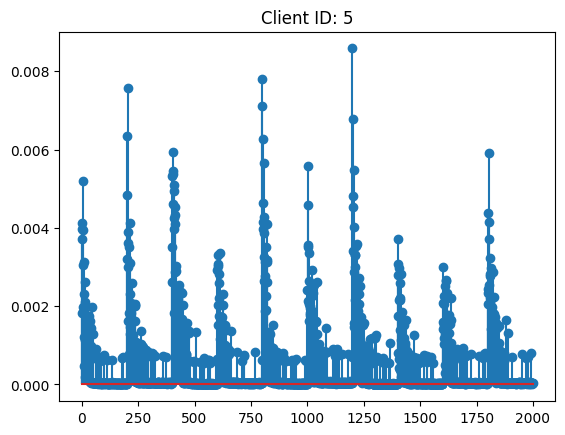

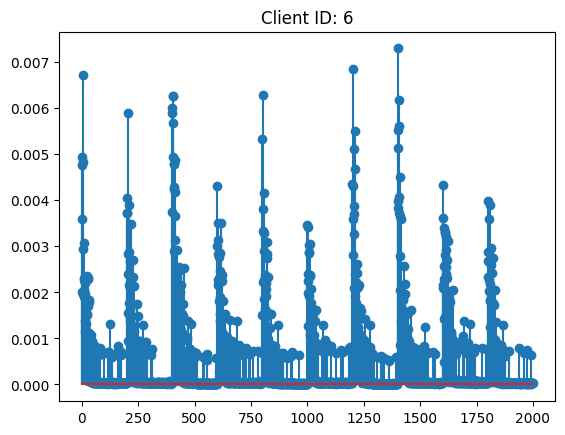

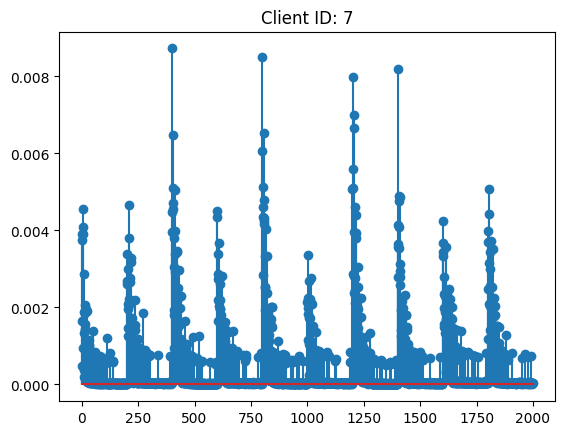

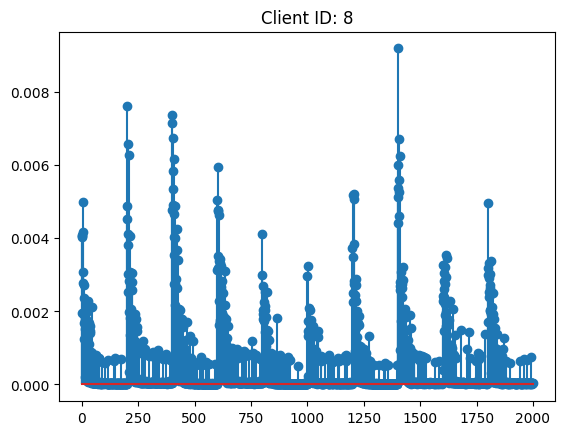

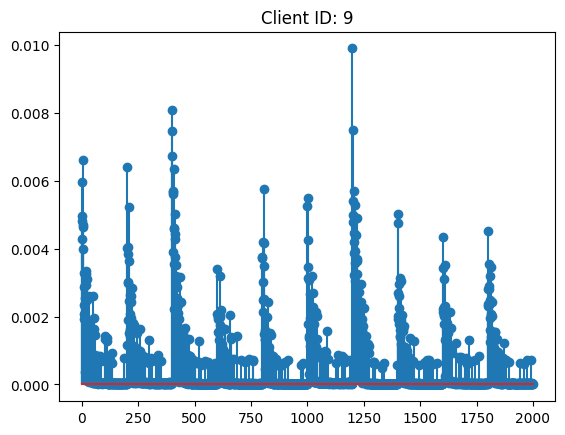

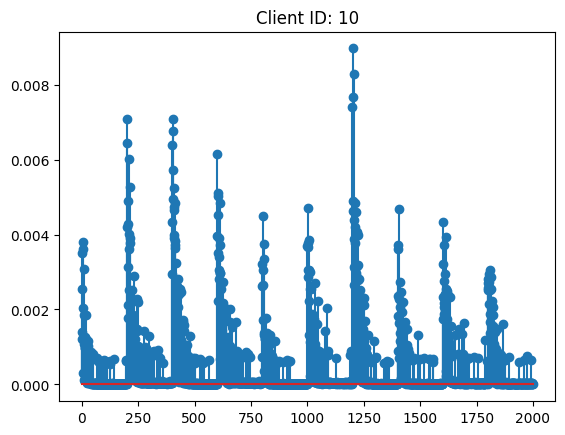

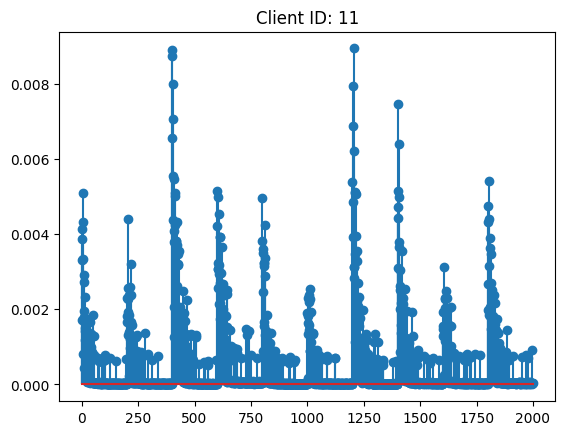

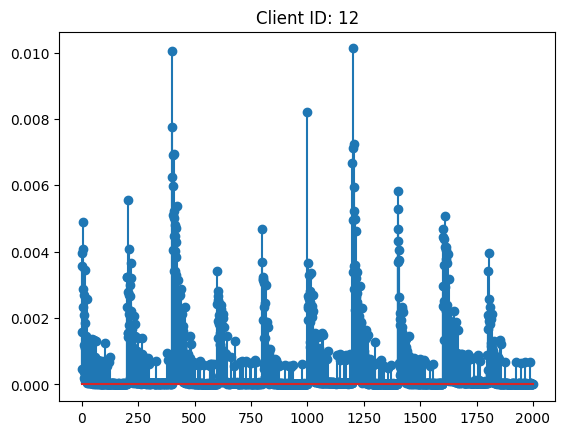

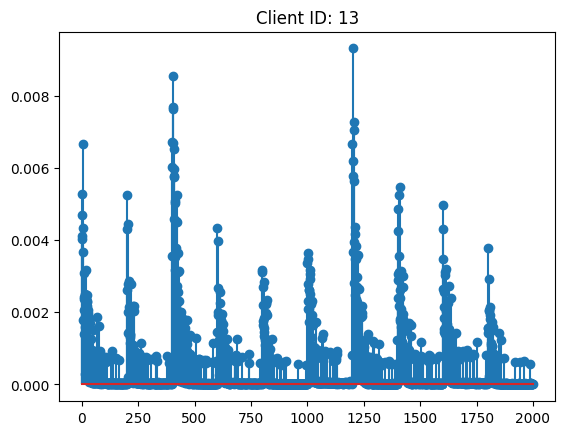

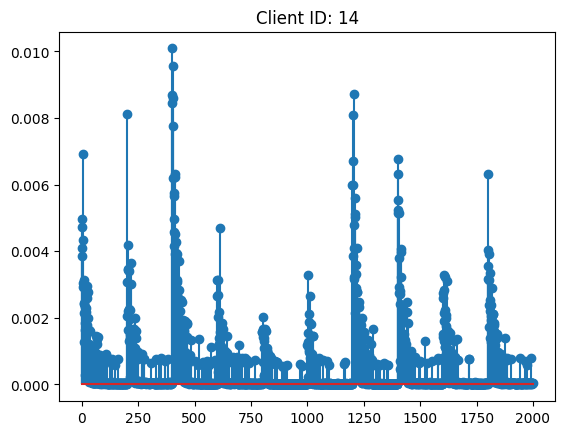

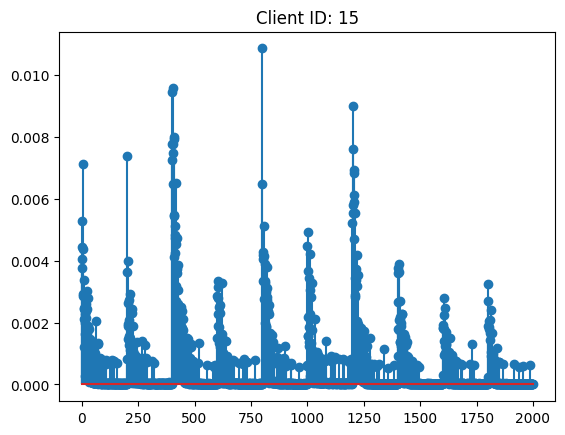

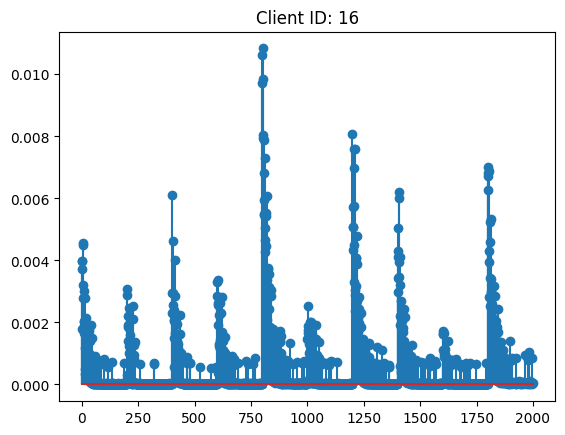

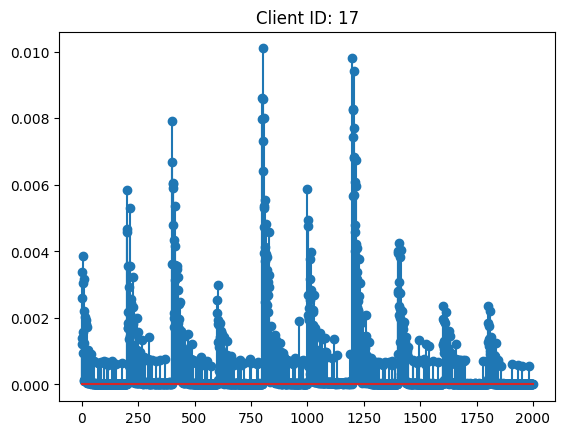

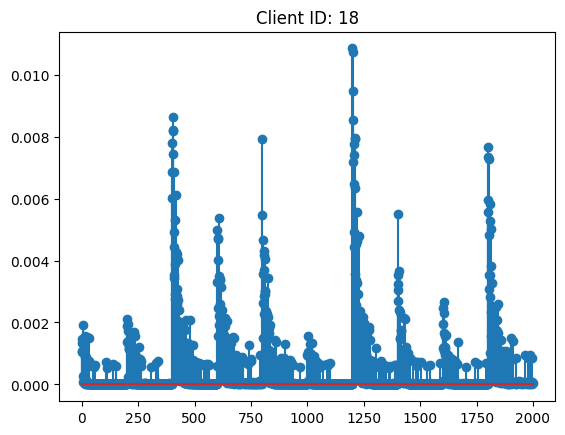

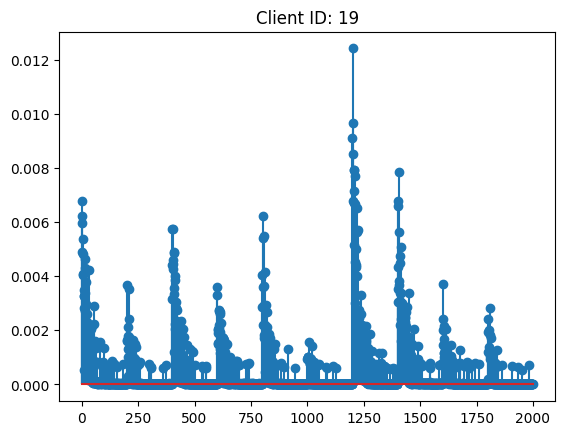

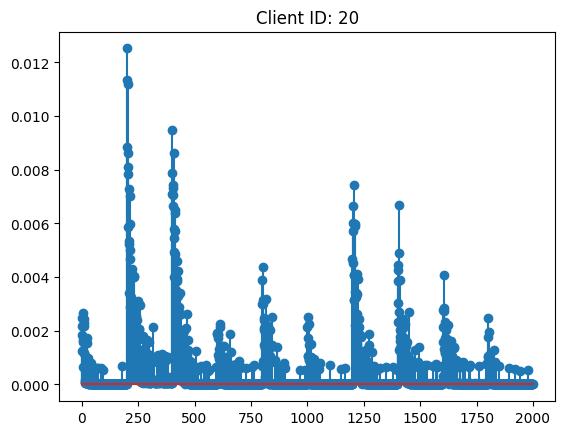

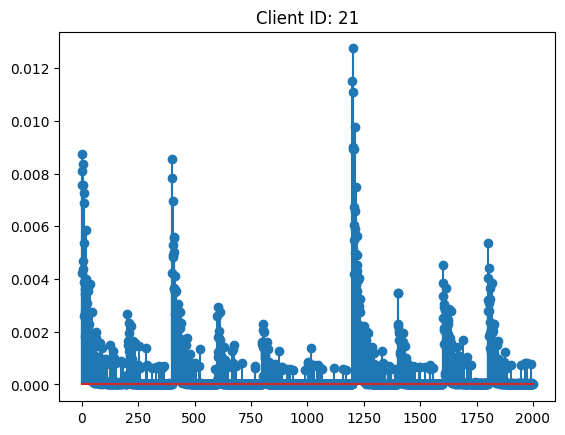

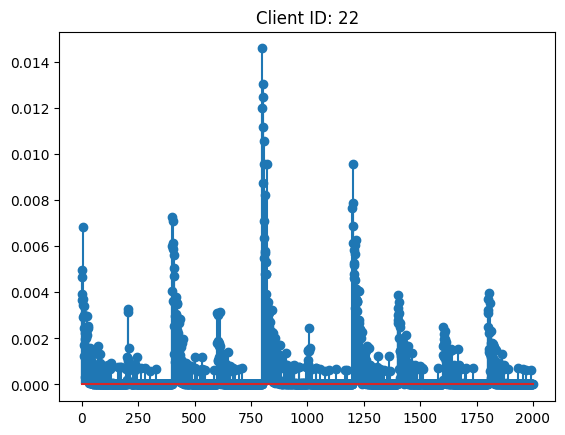

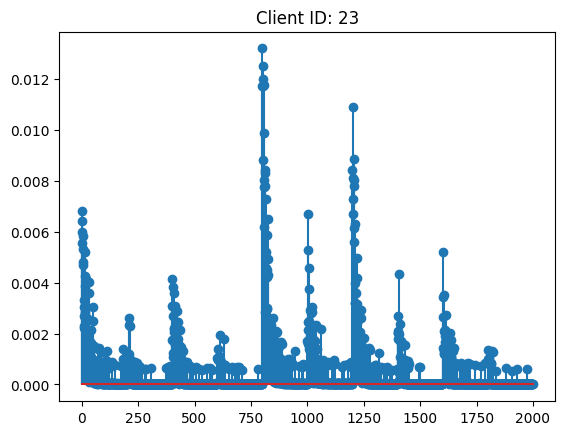

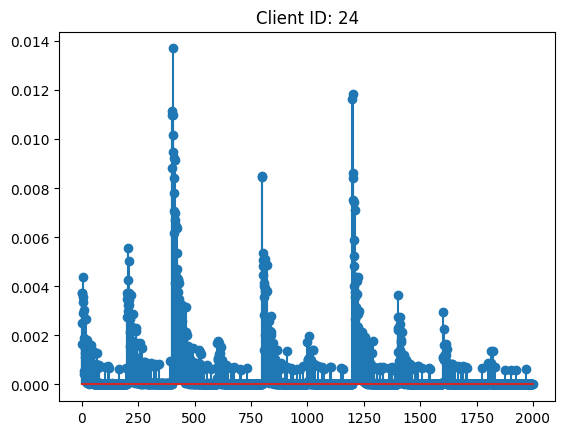

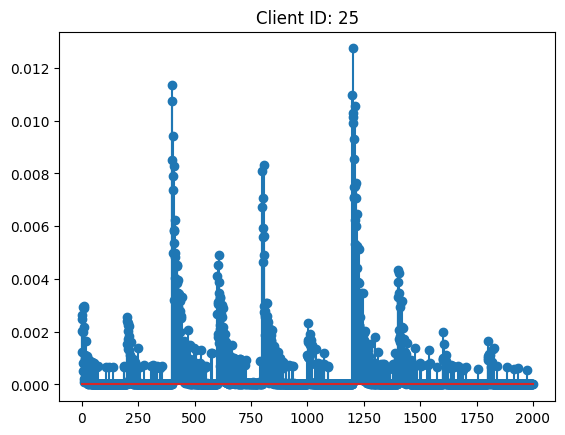

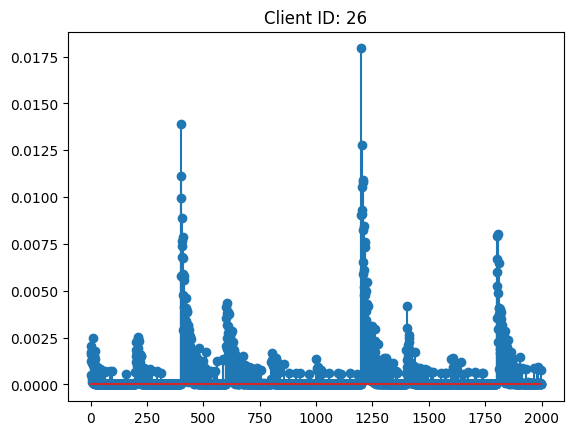

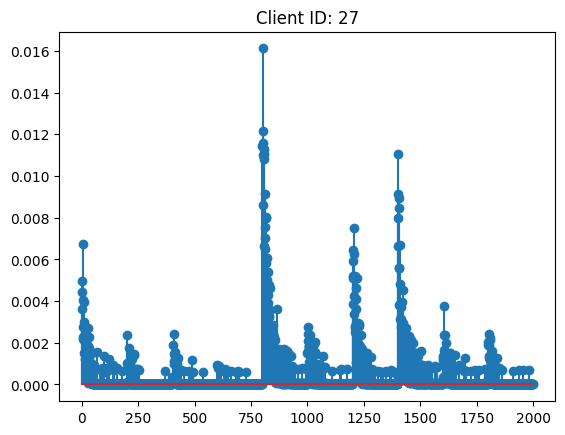

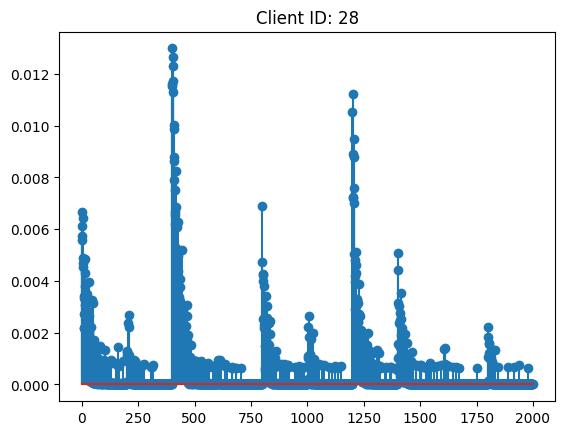

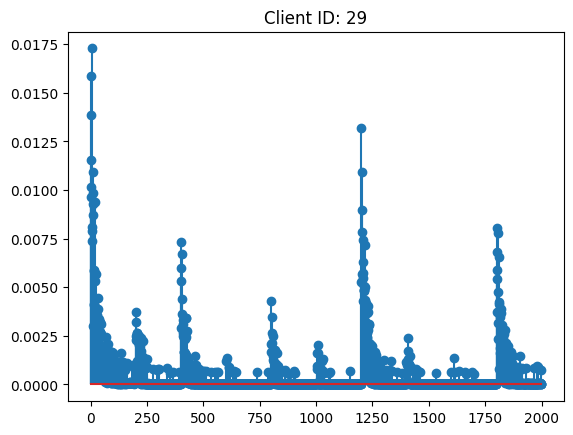

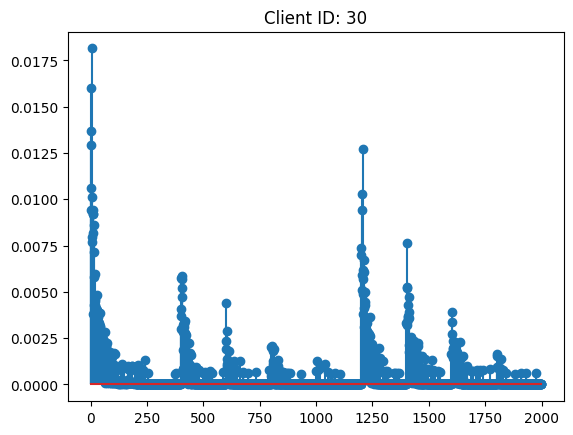

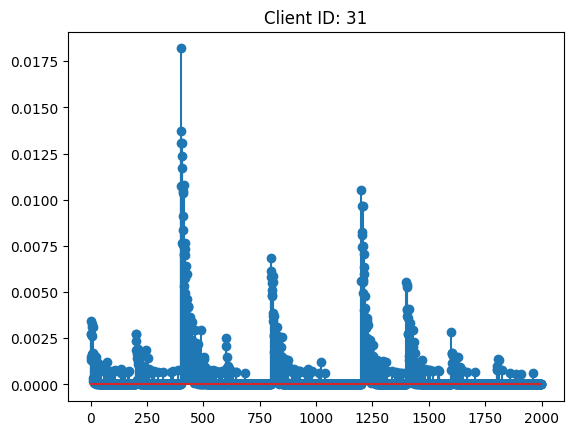

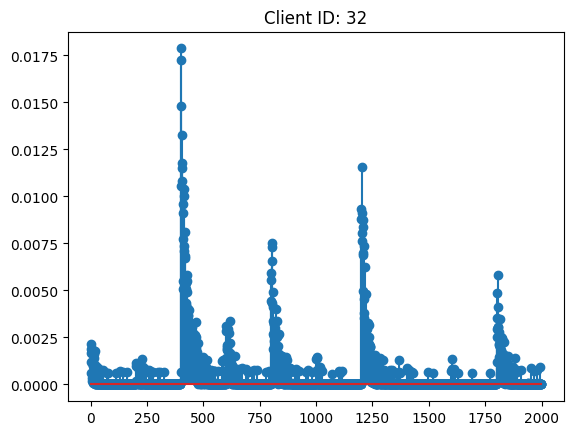

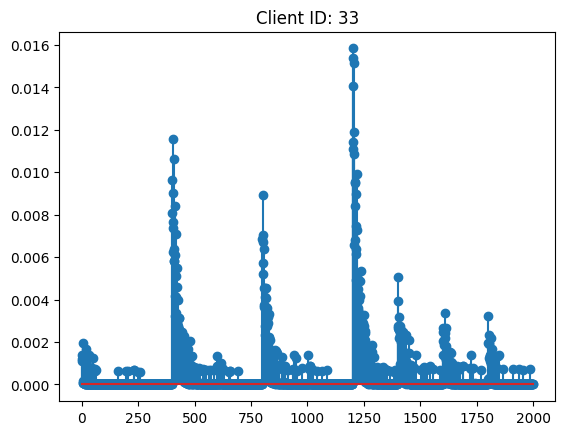

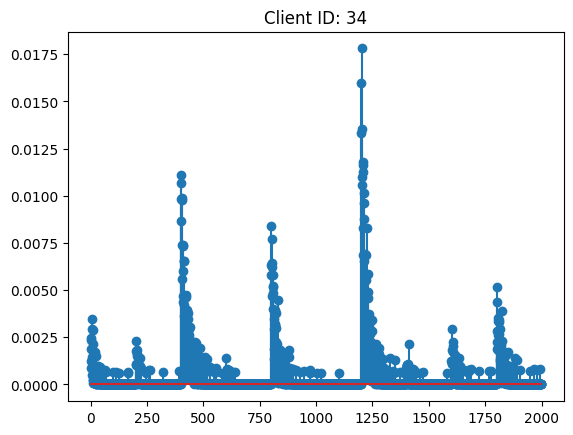

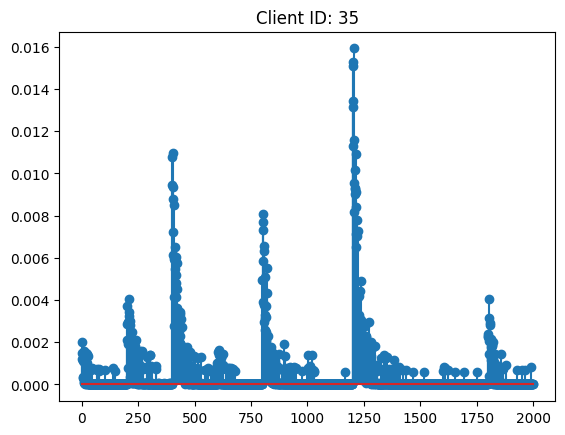

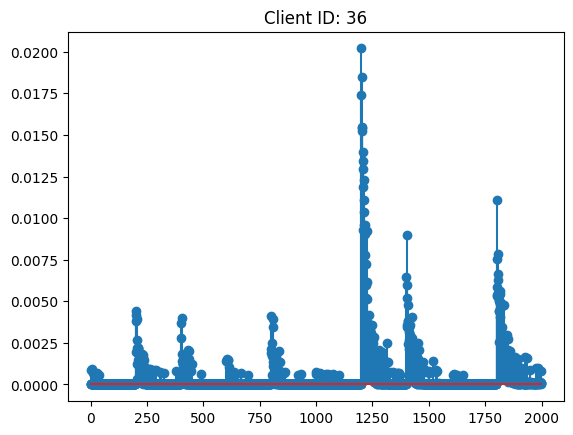

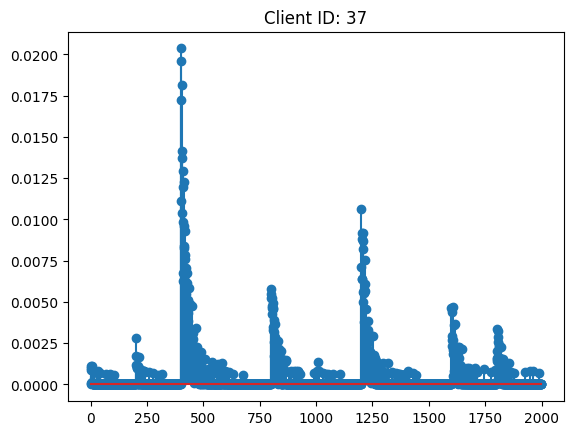

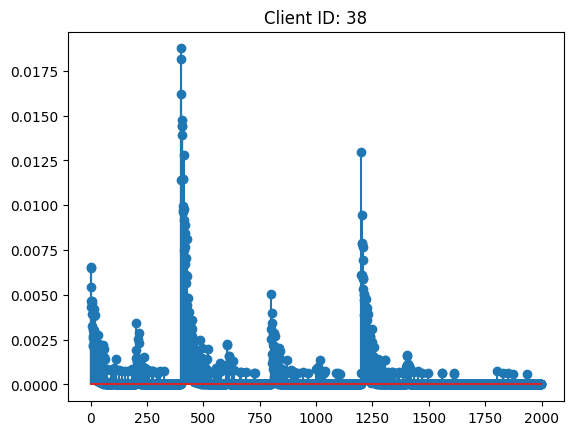

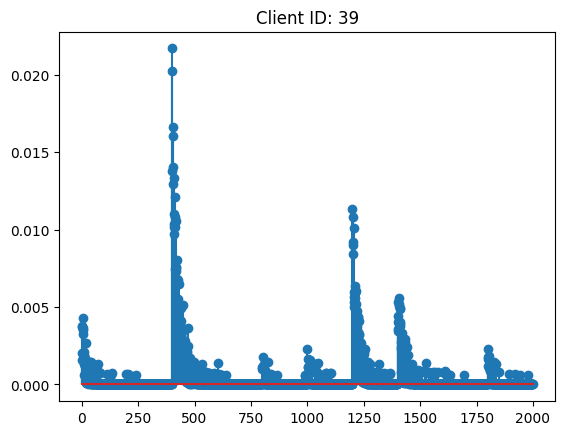

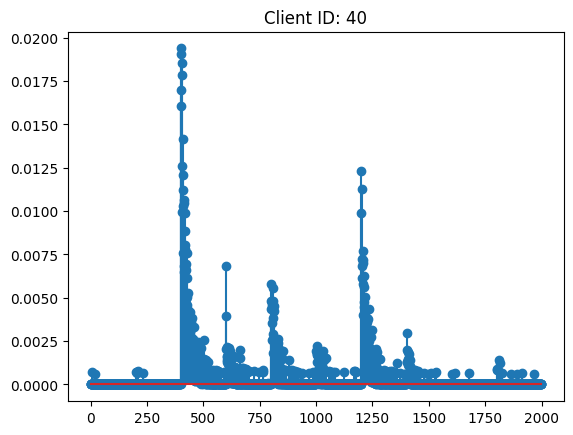

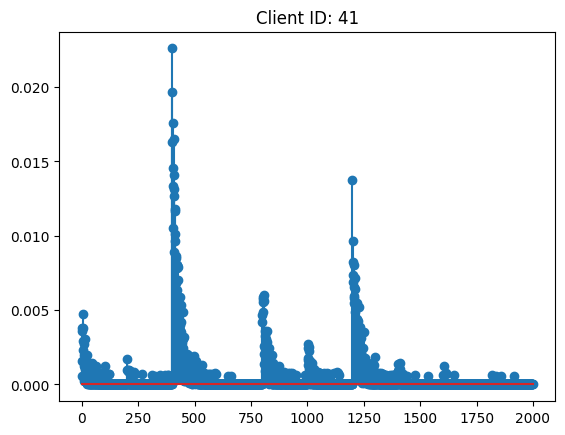

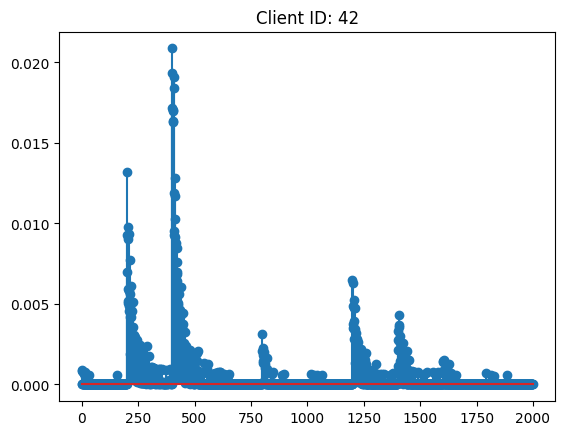

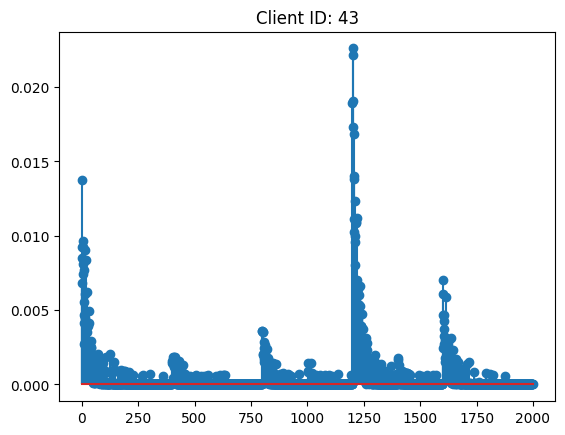

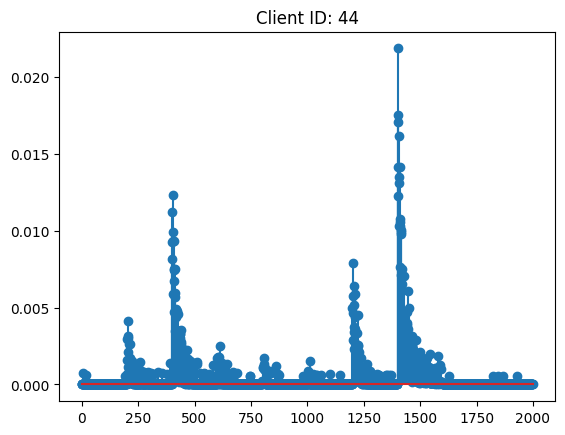

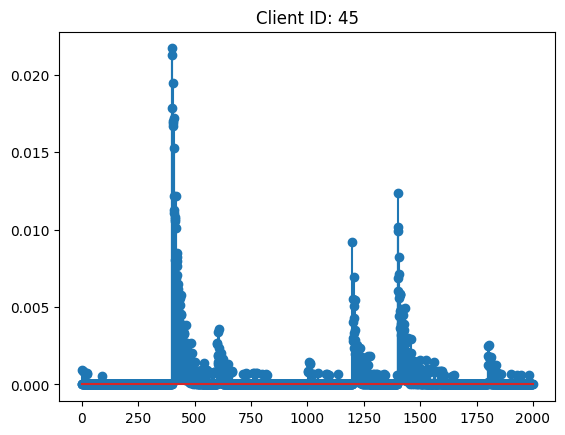

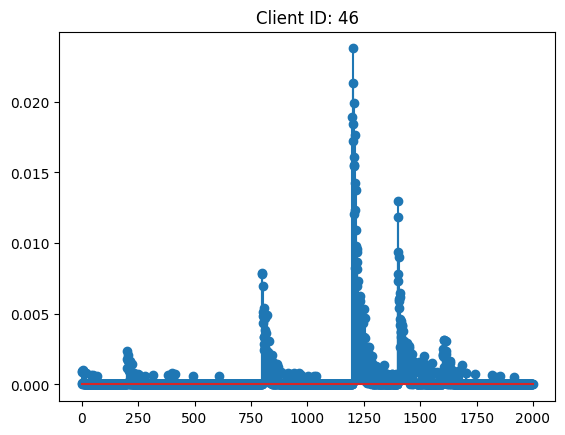

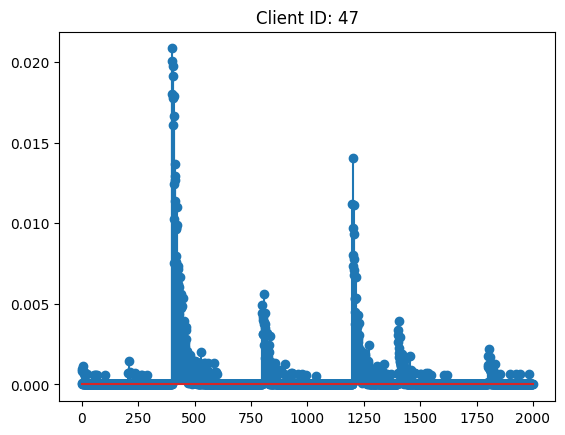

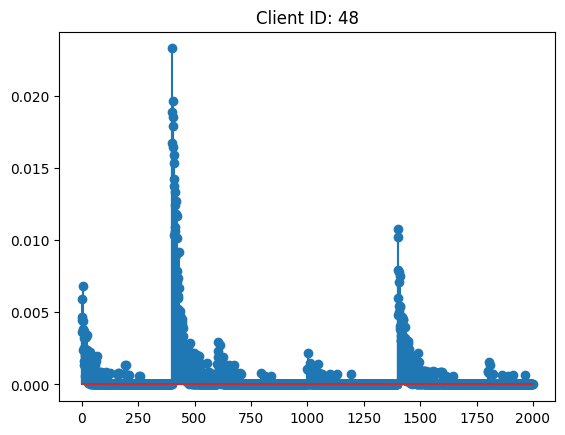

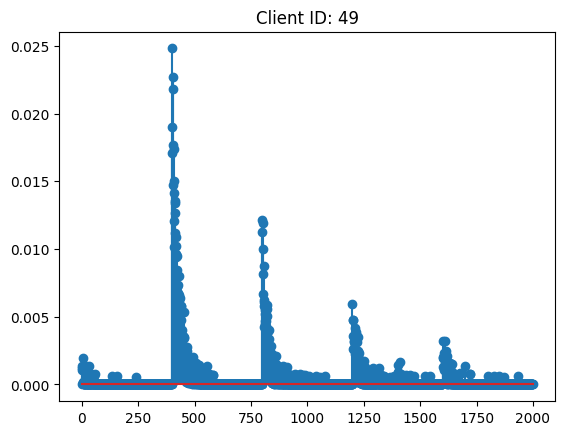

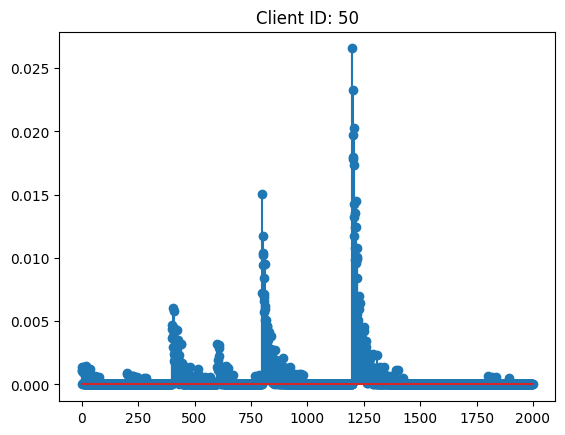

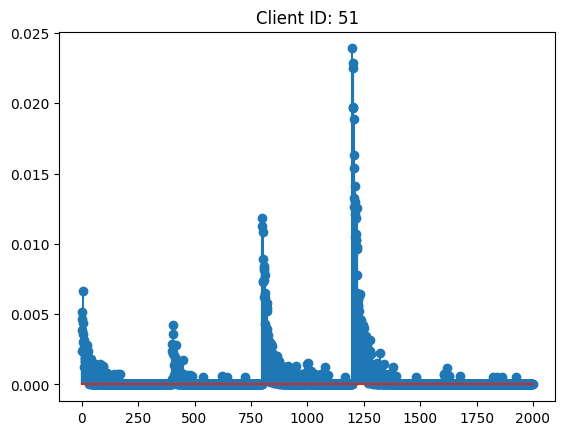

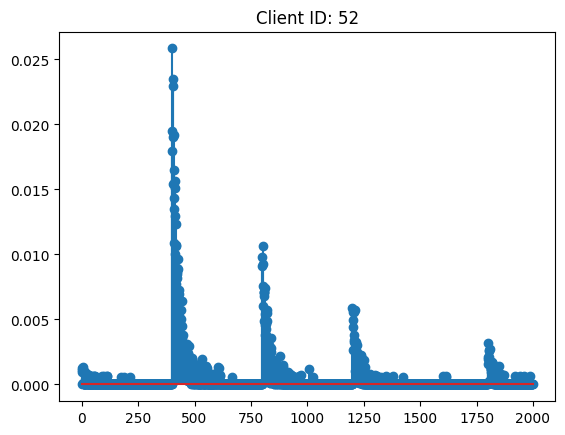

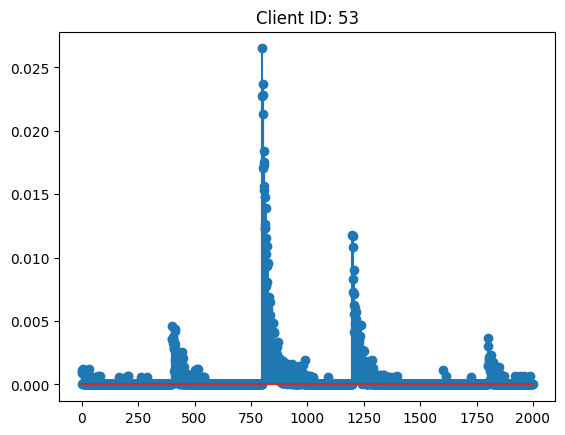

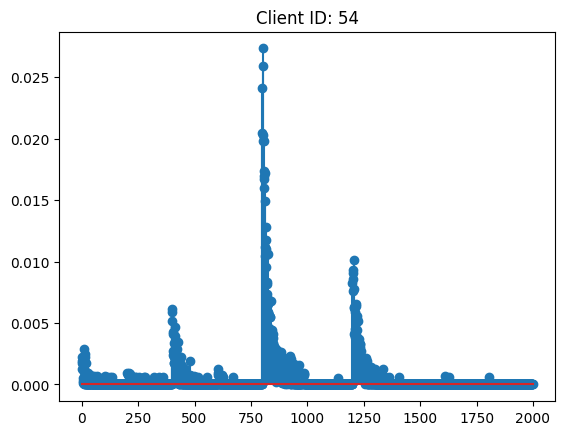

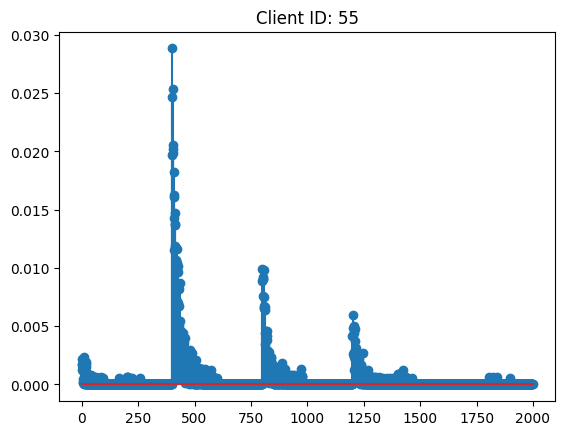

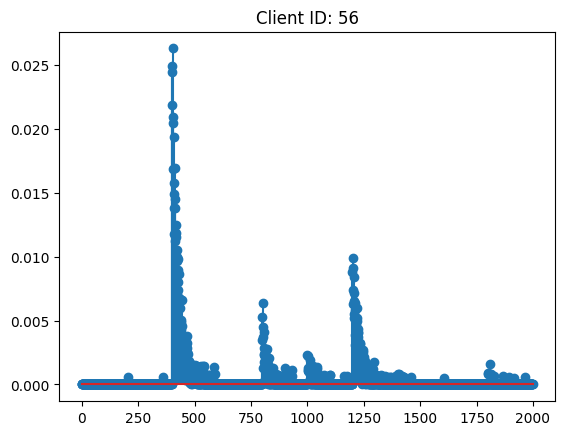

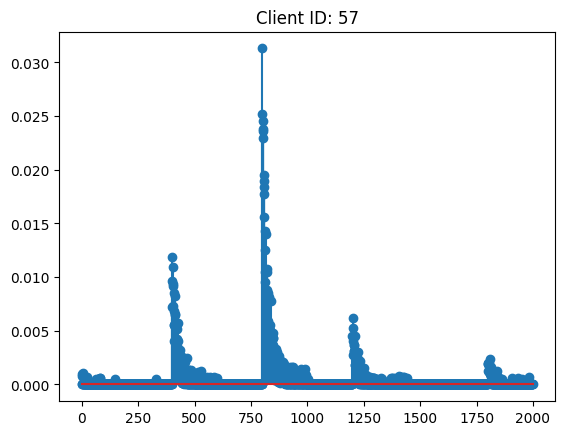

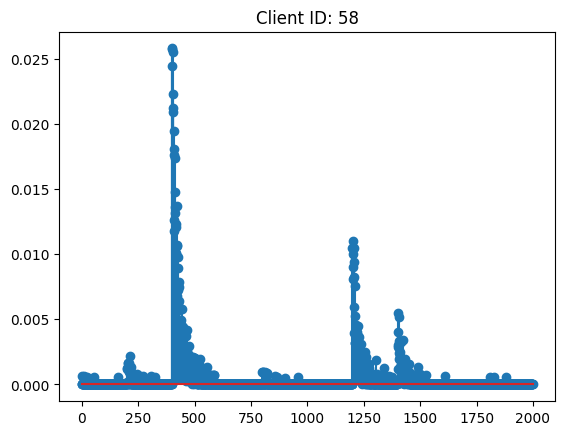

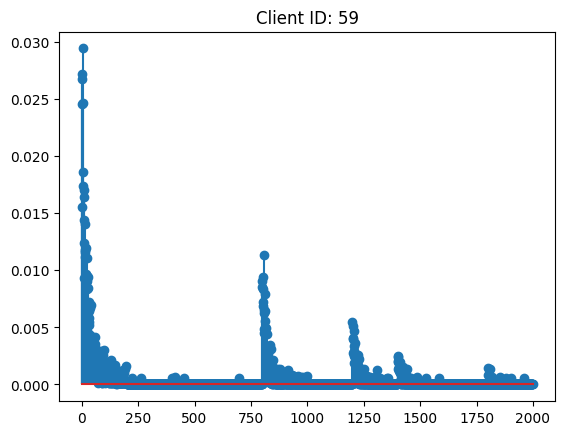

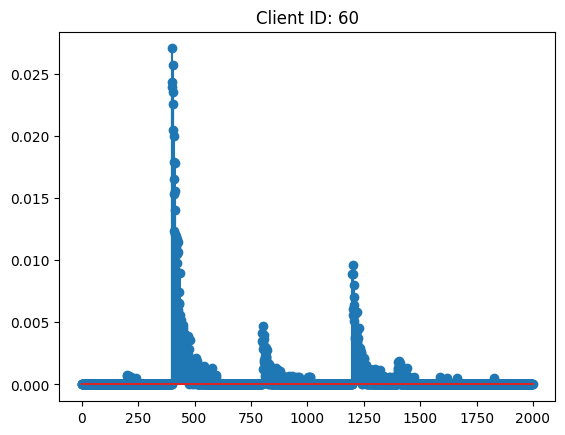

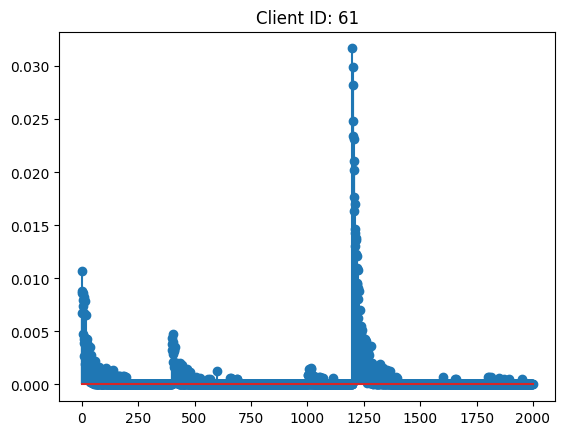

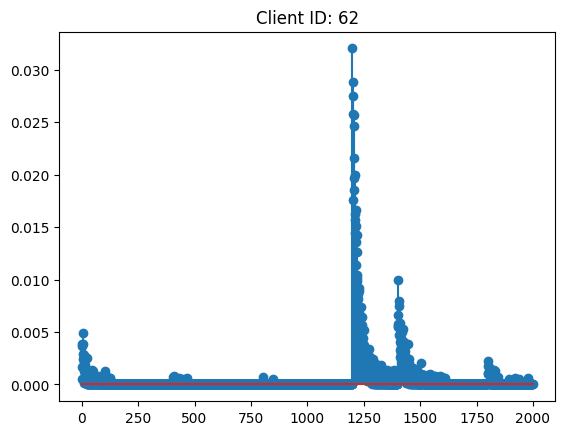

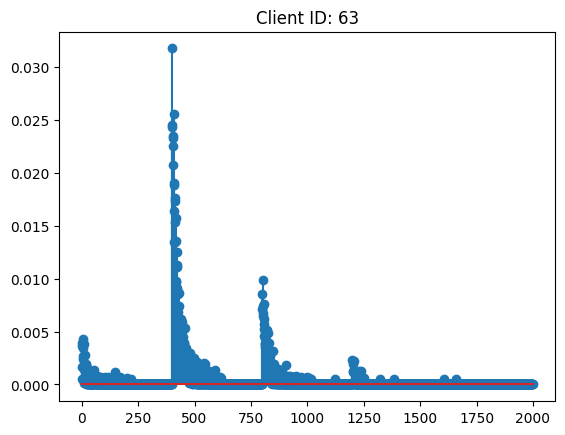

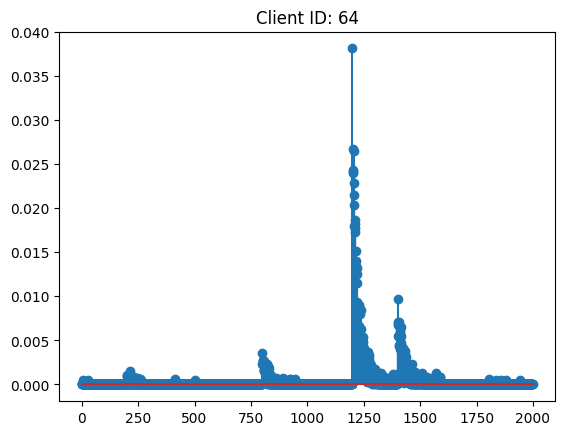

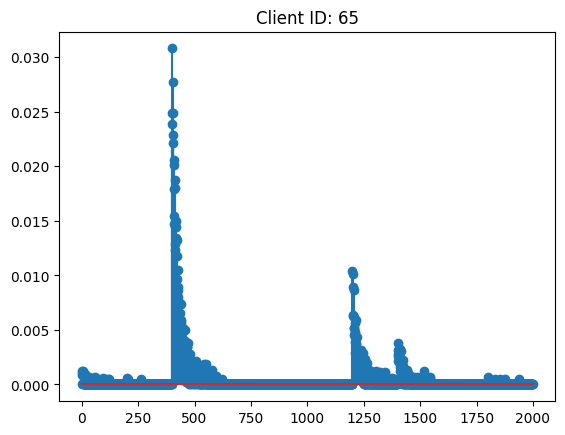

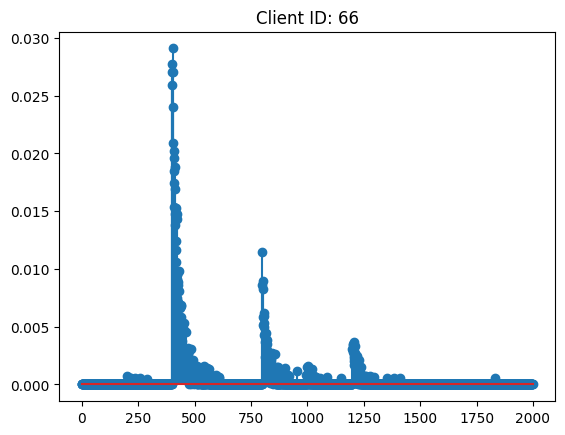

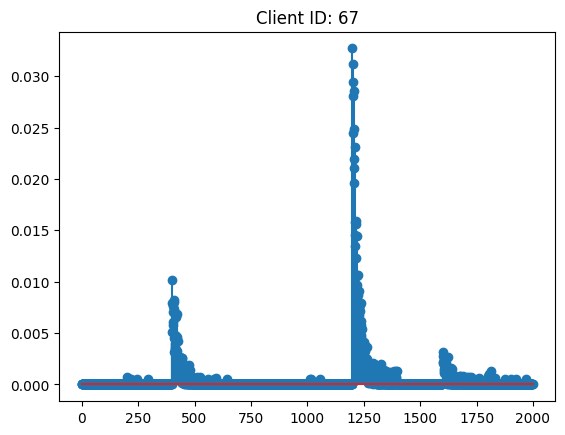

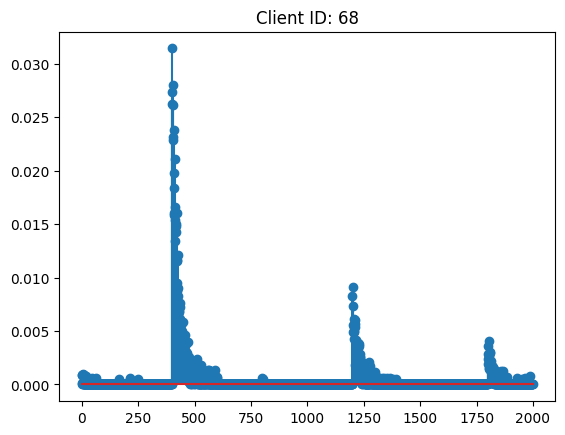

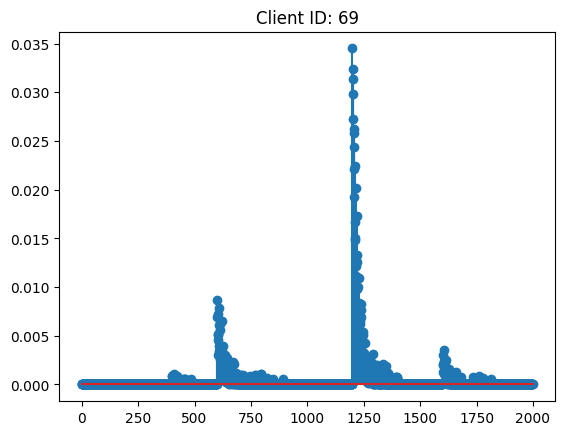

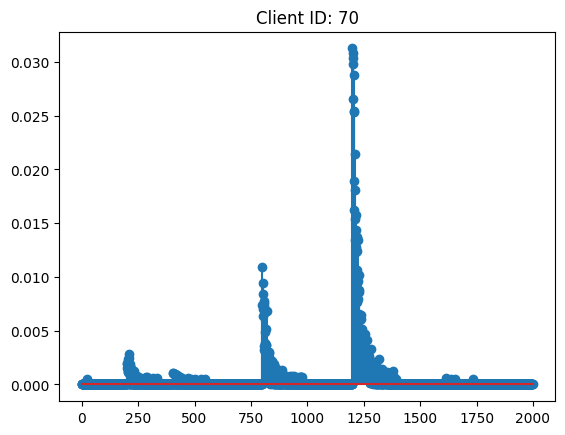

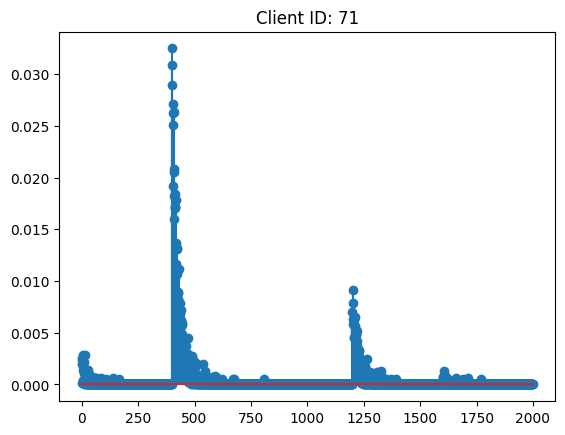

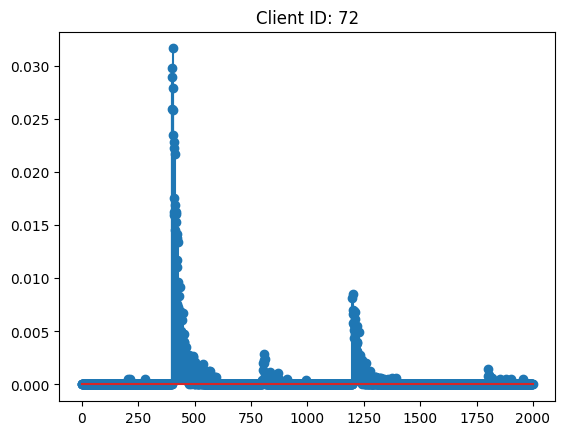

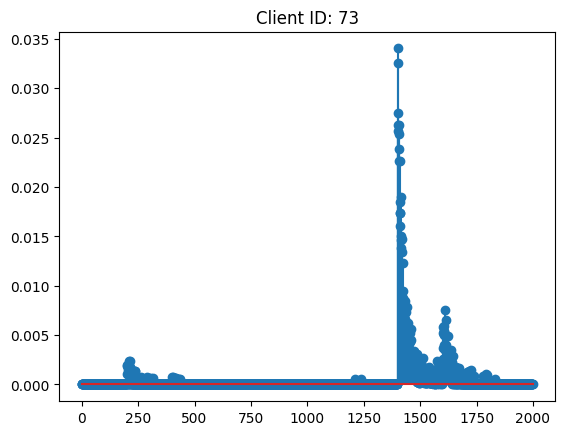

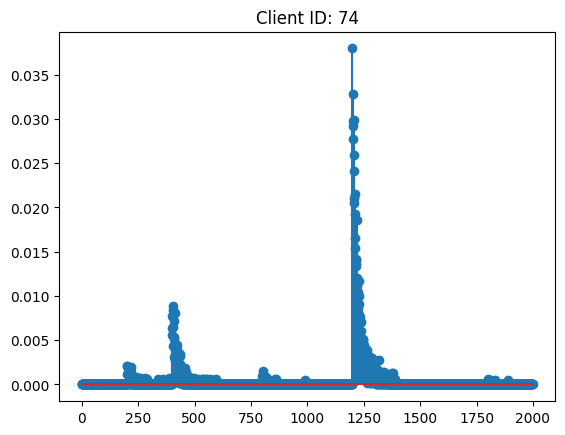

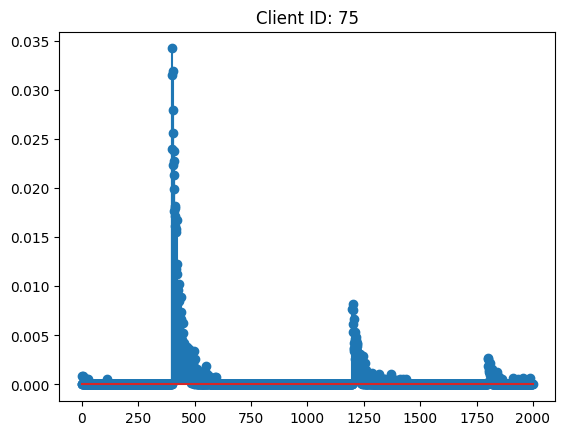

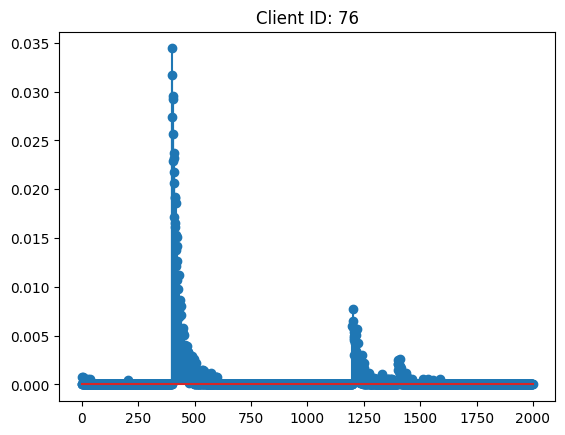

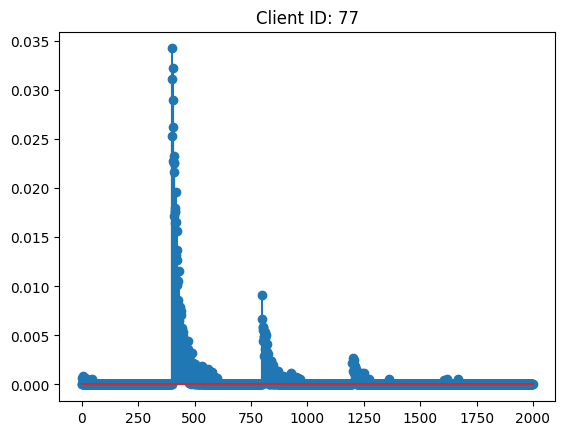

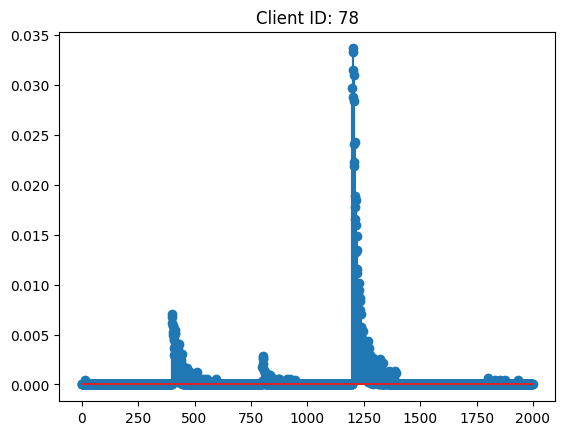

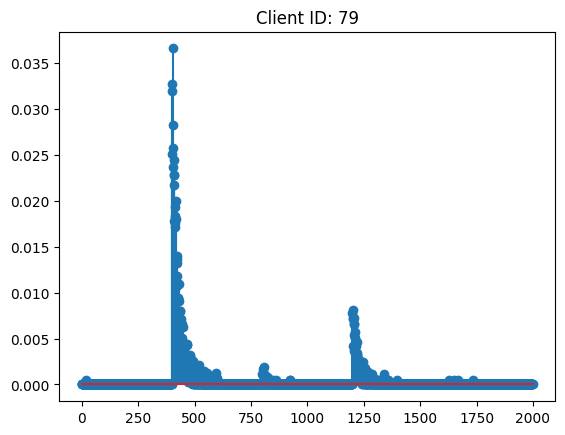

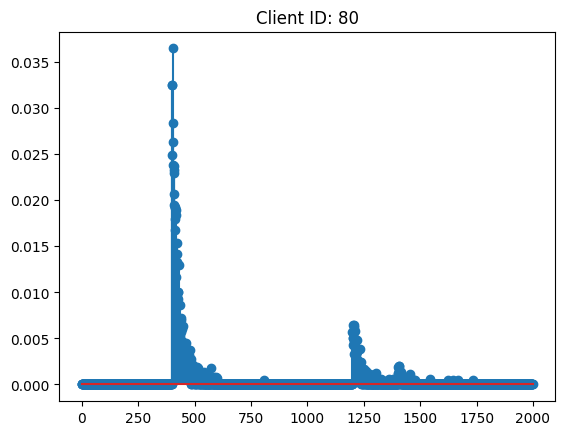

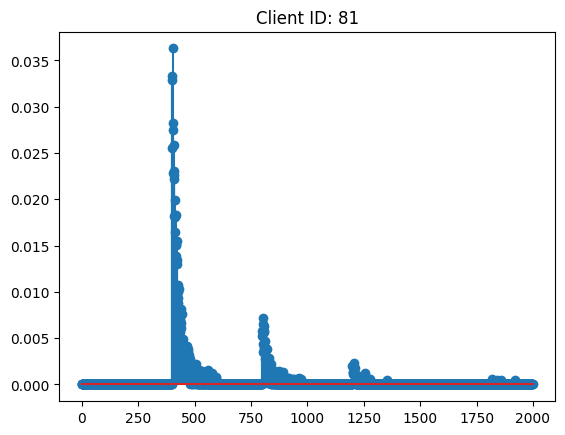

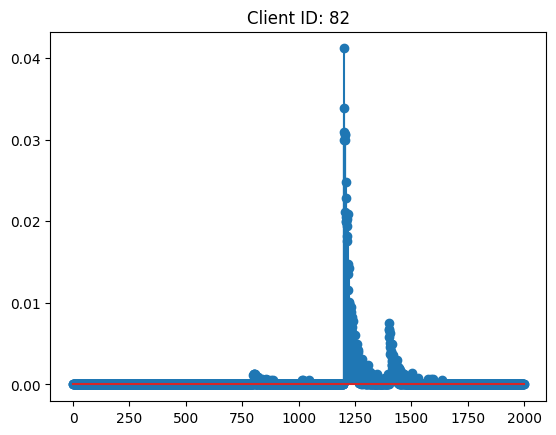

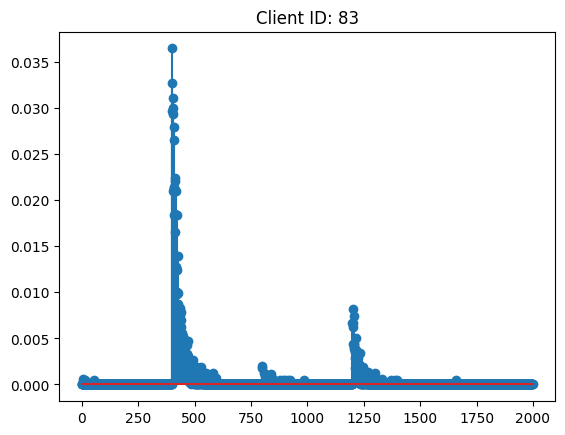

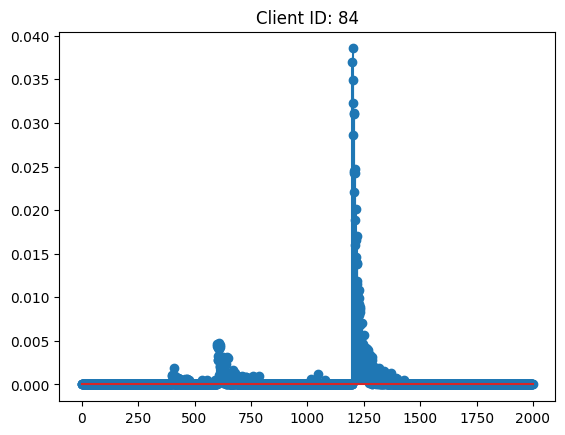

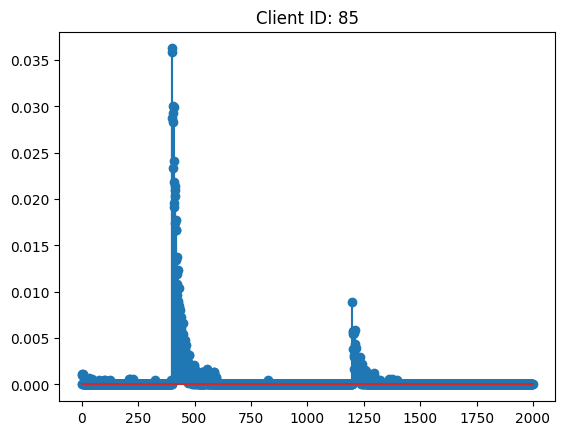

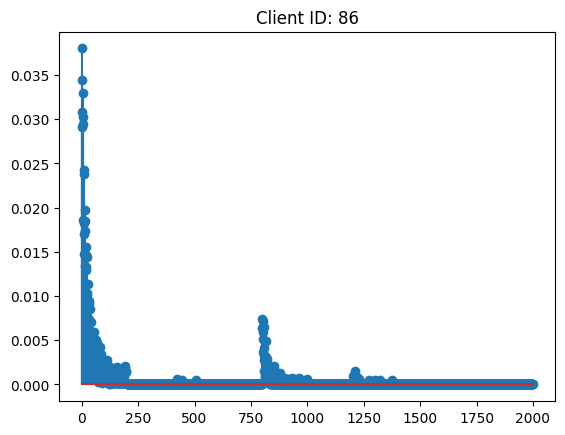

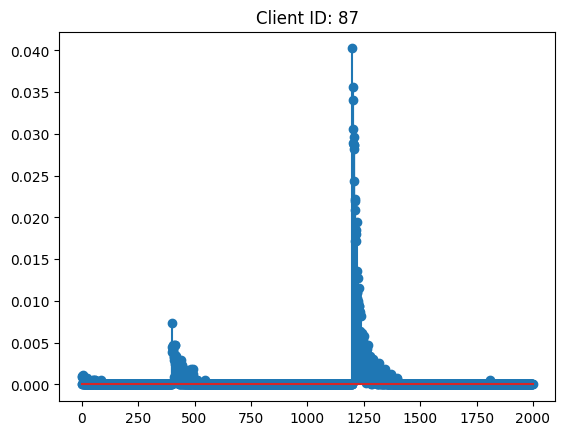

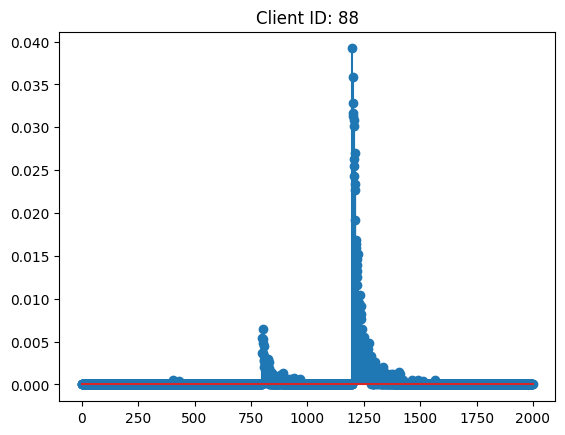

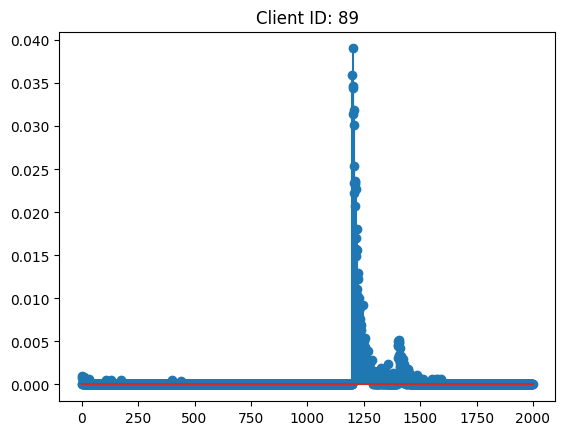

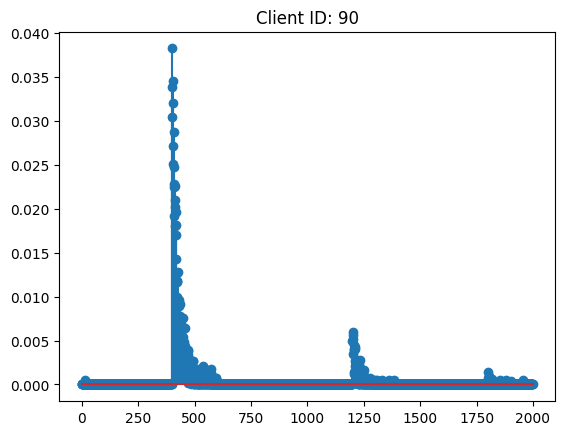

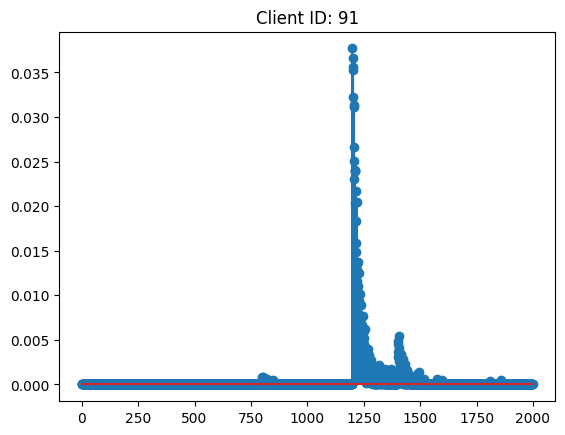

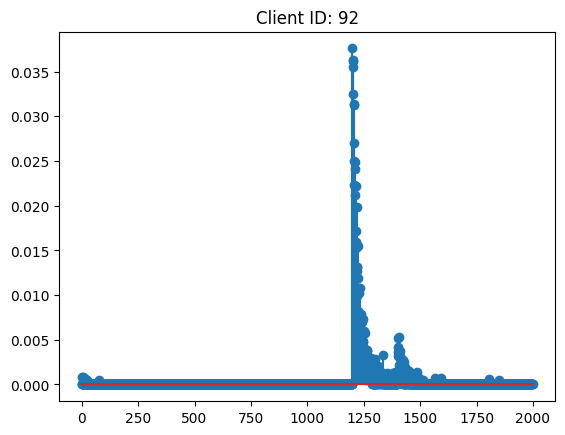

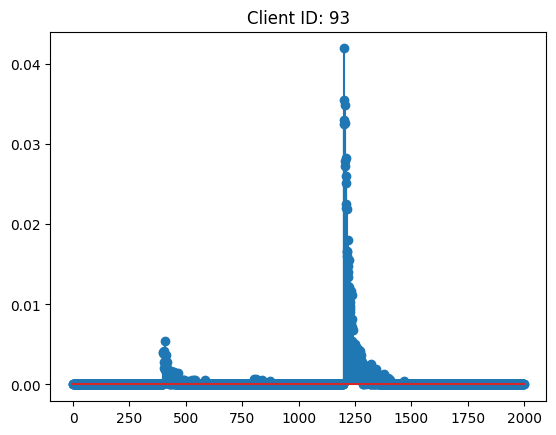

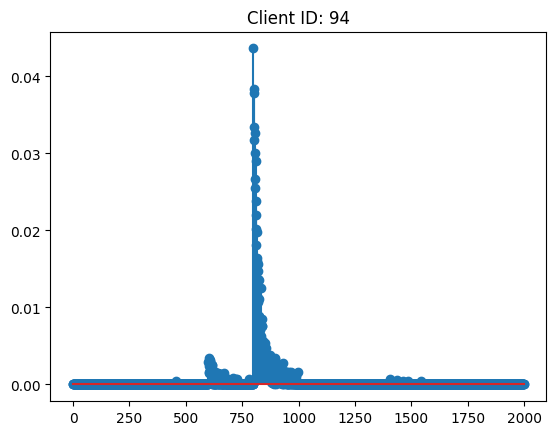

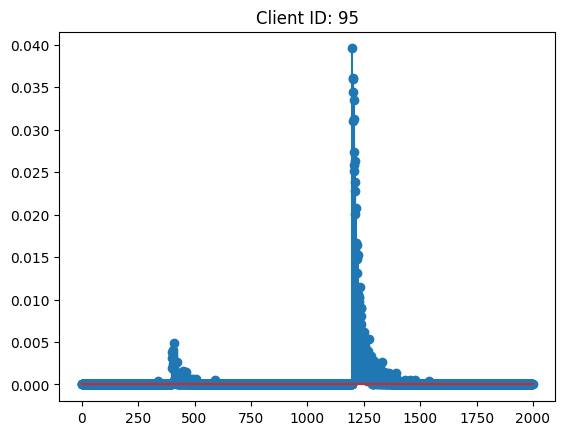

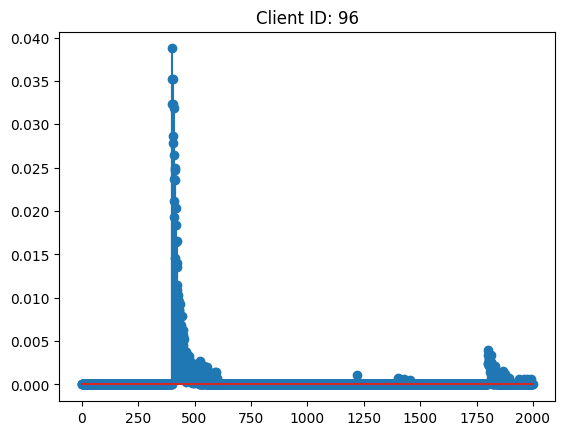

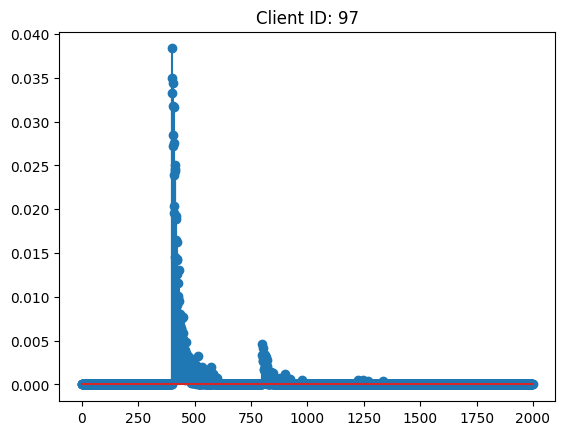

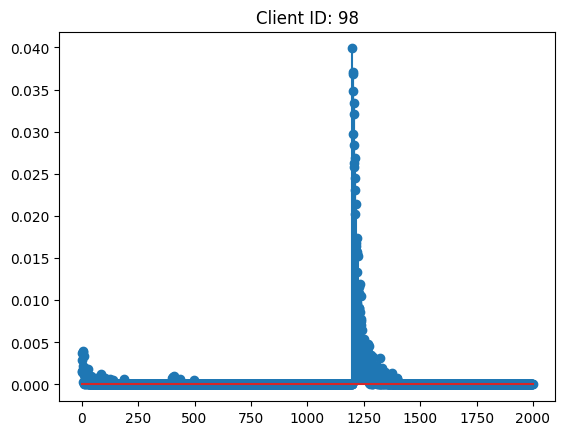

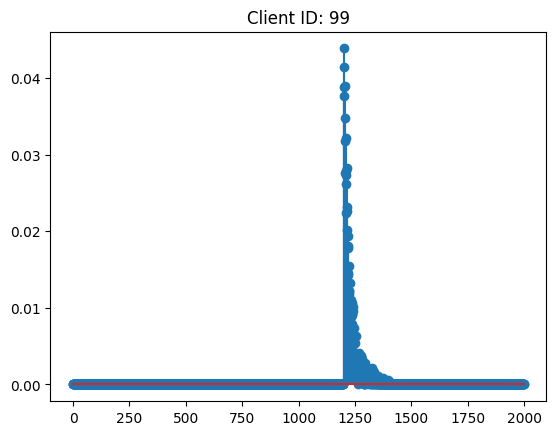

In [47]:
import matplotlib.pyplot as plt
ans = [] ## 추론 저장용
for idx, w in enumerate(w3):
    m1 = VAE().to("cuda:0")
    m1.load_state_dict(w)
    t1 = inference(m1, info, mode = 'global')
    ans.append(t1)
    #plt.title("Client ID: "+str(idx))
    #plt.stem([i for i in range(len(t1))], t1)
    #plt.show()

In [50]:
# with open("inference_0722.pkl", "wb") as f:
#     pickle.dump(ans, f)